# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import packages

# data extraction
from sqlalchemy import create_engine

# standard data processing
import pandas as pd
import numpy as np
import sys
import time

# tokenization
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# visualization libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn liabraries

from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

# saving model results
import joblib



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/oleksandryatsenko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oleksandryatsenko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/oleksandryatsenko/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def load_data():
    '''
    INPUT: 
    none
    
    OUTPUT:
    X,y - extracting features and labels from TweetsDatabase
    '''
    
    # load data from database
    engine = create_engine('sqlite:///TweetsDatabase.db')
    df = pd.read_sql_table('TweetsDatabase', engine)
    
    # defining features - X and labels y
    # dropping 'child alone feature' as this is absent in our data
    X = df['message']
    y = df.drop(['id','original','message','genre','child_alone'], axis = 1)
    
    # Replacing rougue 2 values, otherwise this will cause an error in confusion matrix
    y.related.replace('2','1',inplace=True)
    y = y.astype(int)
    return X,y

### 2. Write a tokenization function to process your text data

In [3]:
def tokenize(text):
    '''
    INPUT: 
    text - individual tweets from TweetsDatabase in string format
    
    OUTPUT:
    clean_tokens - list of cleaned tokens 
    
    '''
    # text cleaning
    text = text.lower() # Convert to lowercase
    text = re.sub('[^A-Za-z0-9]+',' ', text) # removing punctuation
    words = nltk.word_tokenize(text) # tokenizing words
    stop_words = set(stopwords.words('english')) # adding set of stopwords
    filtered_words = [w for w in words if not w.lower() in stop_words] # filtering words
    
    # initiate lemmatizer
    lemmatizer = WordNetLemmatizer()

    # iterate through each token
    clean_tokens = []
    for tok in filtered_words:
        # lemmatization
        clean_tok = lemmatizer.lemmatize(tok)
        clean_tokens.append(clean_tok)
    return clean_tokens

### 3. Assembling model evaluation components

In [4]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    '''
    INPUT: 
    confusion_matrix - results of sklearn confusion_matrix
    axes
    class_label
    class_names
    fontsize
    
    OUTPUT:
    confusion matrix chart 
    
    '''
    # plotting heatmap of confusion matricies
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names,)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

In [5]:
def model_results(y_test, y_pred):
    '''
    INPUT: 
    y_test
    y_pred

    
    OUTPUT:
    labels - feature names (columns)
    ax
    fig 
    vis_arr - multilabel confusion matrix results
    accuracy - model's accuracy
    '''
    
    labels = list(y_test.columns.values)

    # we use multilabel confusion matrix
    vis_arr = multilabel_confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(4, 4, figsize=(18, 9))
    accuracy = (y_pred == y_test).mean()
    
    return labels, ax, fig, vis_arr, accuracy

### 4. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [6]:
def model_pipeline():
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
    ])
    
    # HINT: to check the full set of all parameters we can use in gridsearch - pipeline.get_params()
    parameters = {
        'tfidf__use_idf': (True, False)
        
        # 'clf__n_estimators': [50, 100, 200],
        # 'clf__min_samples_split': [2, 3, 4],
        # 'tfidf__use_idf': (True, False),
        # 'vect__ngram_range': ((1, 1), (1, 2)),
        # 'vect__max_df': (0.5, 0.75, 1.0),
        # 'vect__max_features': (None, 5000, 10000),
    }

    cv = GridSearchCV(pipeline, param_grid=parameters, cv = 3)
    return cv

### 5. Train model
- Split data into train and test sets
- Train model (pipeline)

In [7]:
def build_model(X_train, y_train):
    '''
    INPUT: 
    none
    
    OUTPUT:
    model 
    X_train 
    X_test 
    y_train 
    y_test
    '''
    model = model_pipeline()
    model.fit(X_train, y_train)
    
    return model


### 6. Evaluate your model

In [8]:
def model_evaluation(model, X_train, X_test, y_train, y_test):    
    '''
    INPUT: 
    model
    
    OUTPUT:
    charts & running time
    '''
    
    y_pred = model.predict(X_test)
    
    labels, ax, fig, vis_arr, accuracy = model_results(y_test, y_pred)
    
    for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"]) 
    
    # displaying results
    fig.tight_layout()
    plt.show() 
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy)

### 7. Export your model as a pickle file

In [9]:
def save_model(model):
    '''
    INPUT: 
    model
    
    OUTPUT:
    pickle file of a model
    '''
    joblib.dump(model, "pipeline_model.pkl")

In [10]:
def main():
    start_time = time.time()
    print('Loading data..')
    
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
    
    print('Training model...')
    model = build_model(X_train, y_train)
    
    print('Saving model...')
    save_model(model)
    
    print('Trained model saved!')
    
    print('Evaluating model..')
    model_evaluation(model, X_train, X_test, y_train, y_test)
    
    # predictions running time
    print("Running time:","--- %s seconds ---" % (time.time() - start_time)) 

Loading data..
Training model...
Saving model...
Evaluating model..


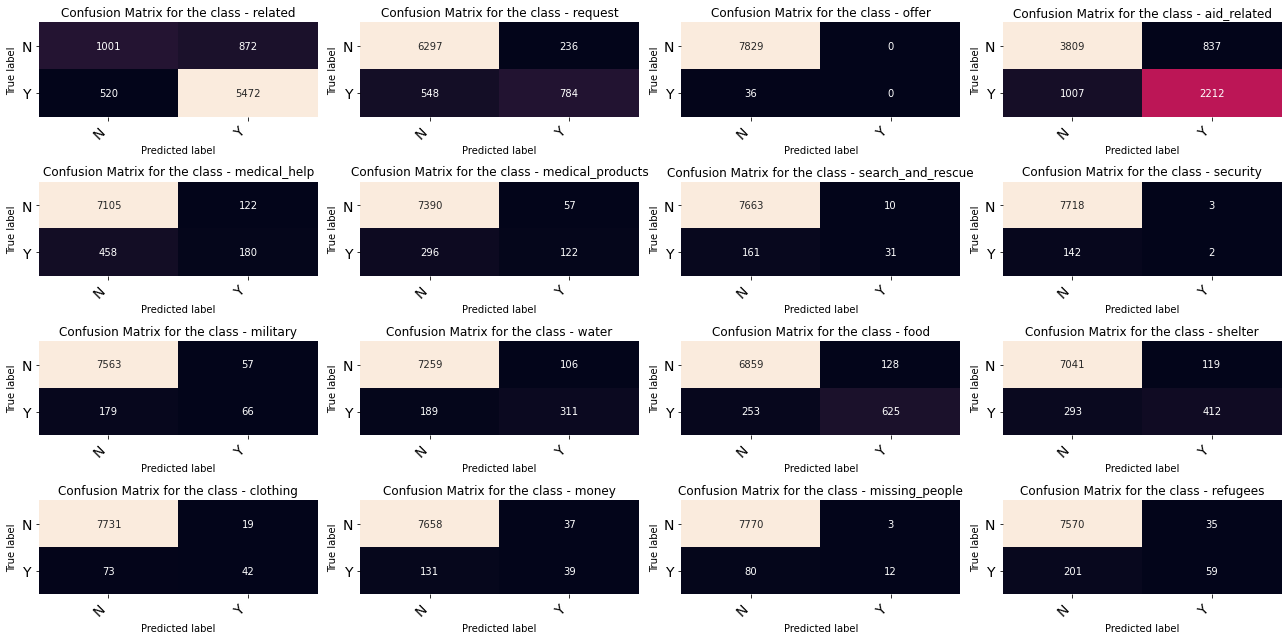

              precision    recall  f1-score   support

           0       0.86      0.91      0.89      5992
           1       0.77      0.59      0.67      1332
           2       0.00      0.00      0.00        36
           3       0.73      0.69      0.71      3219
           4       0.60      0.28      0.38       638
           5       0.68      0.29      0.41       418
           6       0.76      0.16      0.27       192
           7       0.40      0.01      0.03       144
           8       0.54      0.27      0.36       245
           9       0.75      0.62      0.68       500
          10       0.83      0.71      0.77       878
          11       0.78      0.58      0.67       705
          12       0.69      0.37      0.48       115
          13       0.51      0.23      0.32       170
          14       0.80      0.13      0.22        92
          15       0.63      0.23      0.33       260
          16       0.78      0.44      0.57       366
          17       0.50    

/Users/oleksandryatsenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/oleksandryatsenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/oleksandryatsenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

In [11]:
if __name__ == '__main__':
    main()

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.